# Understanding the *UHCW* dataset
The [University Hospitals - Coventry & Warwickshire](https://www.uhcw.nhs.uk) (UHCW) has set up an online [portal](https://www.swiftqueue.co.uk/uhcw.php) to facilitate the booking of blood tests appointments in 18 centers around Coventry (UK).  


Available appointments have been recorded in the dataset `appointments.csv`. 
In this notebook we take a first look at this dataset.  

For speed and since this is still preliminary work, this notebook uses a relatively smaller subset, `sample_appointments.csv`.

---

## Summary of findings
- There are:
 - 18 test centers,
 - serving 2 age groups ("adult" and "child"),
 - delivering a total of 5 different test types, labeled:
   - 'Blood Test'
   - 'INR Test',
   - 'Fasting Bloods',
   - 'Non Fasting Bloods',
   - 'Glucose Tolerance Test'
- Each test center serves only 1 age group.
- Each center delivers 1, 2, or 3 different types of test.
- The centers open their appointments for booking with a varying number of days ahead of time, between 52 and 125.
- Most centers which deliver tests of multiple types put the appointments for all types at the same time.  

In the first part of this notebook, we will display the operations on the dataframes.  In the second part we will invoke the custom class `UHCW`.


## Remark on the code##  
In later notebooks we will use custom functions and classes.  Here we deliberately stick to standard modules.

---

## Imports

In [1]:
import os
import pytz
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

Record time of beginning of script:

In [2]:
beg_script = datetime.datetime.now()

## Constants

In [3]:
tz_utc = pytz.timezone("UTC")  # grab timestamp is in UTC standard
tz_london = pytz.timezone("Europe/London")  # test centers are in Coventry, UK

IMG_DIR = os.path.join(os.path.expanduser("~"), "Projects/UHCW/IMAGE_FILES")

## Data
Read in the `csv` file.

In [4]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
foldername = 'Projects/UHCW/datasets'
# Choose from among datasets of various sizes (various collection periods or centers)
# filename = 'appointments-tiny.csv'
# filename = 'appointments-less-tiny.csv'
# filename = 'appointments-one-week-two-centers.csv'
filename = 'appointments-24-hours.csv'
# filename = 'appointments-one-week.csv'
# filename = 'appointments-three-weeks.csv'filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')
raw_data.rename(
    index=str,
    columns={
        'center id': 'id',
        'test type': 'test',
        'appointment timestamp': 'appointment',
        'center age group': 'age group',
        'grab timestamp': 'grab'
    },
    inplace=True
)

Time: 12:24:50
Size of data file: 291MB.
Loading data...
CPU times: user 3.88 s, sys: 379 ms, total: 4.26 s
Wall time: 4.26 s


## The working dataframe `schedule`
Let's look at the dataframe `raw_data`:

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5117059 entries, 0 to 5117058
Data columns (total 5 columns):
appointment    object
age group      object
id             int64
test           object
grab           object
dtypes: int64(1), object(4)
memory usage: 234.2+ MB


Each row contains information about an available appointment at the time the data was collected:  
- the `appointment` column gives the timestamp (in the local timezone, Coventry, UK) of the appointment;
- the `grab` column gives the timestamp (in the UTC standard) when the data was collected;
- the `id` column gives the id number of the test center of the appointment;
- the `age group` column gives the age group of the population served ("adult" or "child");
- the `test` column gives the type of test administered.

We will work with a copy, `schedule`, and perform type conversion.  

**Note.** The timestamp localization and conversion may take some time on a regular computer (several minutes for 5117059 records).

In [6]:
%%time
schedule = raw_data.copy()

schedule['appointment'] = pd.to_datetime(schedule['appointment'])
schedule['grab'] = pd.to_datetime(schedule['grab'])

schedule = schedule[['id', 'test', 'age group', 'grab', 'appointment']]

schedule['appointment'] = schedule['appointment'].apply(
    lambda ts: ts.tz_localize(tz_london)
)
schedule['grab'] = schedule['grab'].apply(
    lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_london)
)

CPU times: user 4min 21s, sys: 3.5 s, total: 4min 24s
Wall time: 4min 22s


In [7]:
schedule.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5117059 entries, 0 to 5117058
Data columns (total 5 columns):
id             int64
test           object
age group      object
grab           datetime64[ns, Europe/London]
appointment    datetime64[ns, Europe/London]
dtypes: datetime64[ns, Europe/London](2), int64(1), object(2)
memory usage: 234.2+ MB


For emphasis, in the new dataframe `schedule`,  both the `appointment` and `grab` timestamps are in the local timezone (London, UK), and they are both in the format "YYYY-MM-DD hh:mm:ss".  

---
## First observations

There are 18 test centers serving 2 age groups and delivering a total of 5 types of blood tests:

In [8]:
schedule[['id', 'age group', 'test']].nunique().rename("count").to_frame()

,count
id,18
age group,2
test,5


The two categories in the `age group`:

In [9]:
print("\n".join(list(schedule['age group'].unique())))

adult
child


The `test type`s are:

In [10]:
print("\n".join(list(schedule['test'].unique())))

Blood Test
INR Test
Fasting Bloods
Non Fasting Bloods
Glucose Tolerance Test


Each test center serves only one age group:

In [11]:
schedule.groupby('id')['age group'].unique().rename("age group").to_frame()

,age group
id,
10136,[adult]
10137,[adult]
10138,[adult]
10188,[adult]
10207,[adult]
10243,[adult]
10244,[adult]
10250,[adult]
10254,[child]


 but delivers up to three types of blood test.  These are:

In [12]:
center_test_types = schedule.groupby('id')['test'].unique().rename("test types").to_frame()
center_test_types

,test types
id,
10136,"[Fasting Bloods, Non Fasting Bloods, INR Test]"
10137,[Blood Test]
10138,[Blood Test]
10188,"[Blood Test, INR Test]"
10207,[Blood Test]
10243,"[Blood Test, INR Test]"
10244,"[Blood Test, INR Test]"
10250,"[Blood Test, INR Test]"
10254,[Blood Test]


## Dropping the column `age group`
We will no longer be using the column `age group`:

In [13]:
schedule.drop('age group', axis=1, inplace=True)

## Ordering the data by test center

### Order centers by number of test types

We can sort the test centers by the number of test types:

In [14]:
centers_ordered_by_test_types = schedule.groupby('id')['test'].nunique().reset_index().sort_values(
    ['test', 'id']).rename(
    index=str, columns={'id': 'center id', 'test': 'nb of test types'}
).set_index("center id")
centers_ordered_by_test_types

,nb of test types
center id,
10137,1
10138,1
10207,1
10254,1
10294,1
10299,1
10301,1
10336,1
10341,1


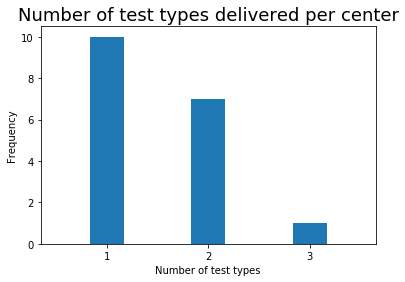

In [15]:
fig, ax = plt.subplots()
centers_ordered_by_test_types['nb of test types'].hist(range=(0.5, 3.5), bins=9);
ax.set_title("Number of test types delivered per center", fontsize=18);
ax.set_xlabel("Number of test types");
ax.set_xticks([1, 2, 3]);
ax.set_ylabel("Frequency");
ax.grid();

### Order centers by number of records

We can sort the centers by the number of records:

In [16]:
centers_ordered_by_records = schedule.groupby('id')['test'].count().reset_index().sort_values(
    ['test', 'id']).rename(
    index=str, columns={'id': 'center id', 'test': 'nb of records'}
).set_index("center id")
centers_ordered_by_records

,nb of records
center id,
10254,25479
10336,32729
10299,34530
10294,40068
10301,49209
10138,118360
10263,157930
10341,179054
10449,212447


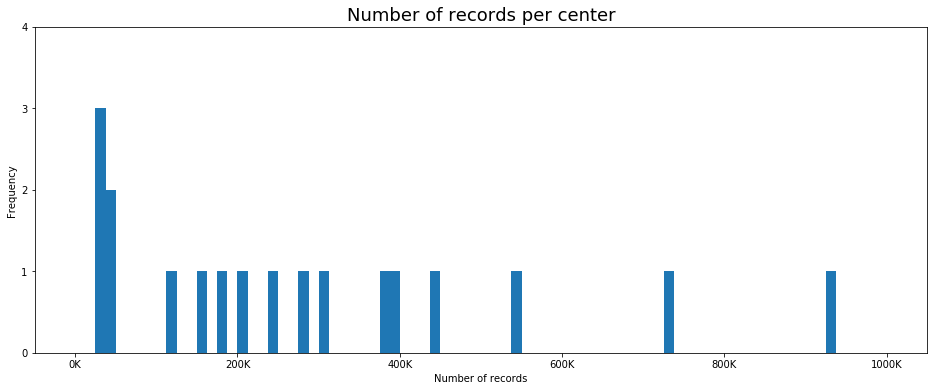

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))
centers_ordered_by_records['nb of records'].hist(ax=ax, range=(0, 1*1e6), bins=80);
ax.set_title("Number of records per center", fontsize=18);
ax.set_xlabel("Number of records");
ax.set_xticklabels(["{0}K".format(int(x//1e3)) for x in ax.get_xticks()])
ax.set_ylabel("Frequency");
ax.set_yticks(range(5))
ax.grid();
#plt.savefig("number-of-records-per-center-distribution.png")

We can combine these two in a new dataframe:

In [18]:
grouped_cid = schedule.groupby('id')
df1 = grouped_cid['test'].nunique().reset_index()
df1['count'] = grouped_cid['test'].count().reset_index()['test']

df1.sort_values(by=['test', 'count']).rename(
    index=str, columns={'id': 'center id', 'test': 'nb of test types', 'count': 'nb of records'}
).set_index("center id")

,nb of test types,nb of records
center id,,
10254,1,25479
10336,1,32729
10299,1,34530
10294,1,40068
10301,1,49209
10138,1,118360
10341,1,179054
10449,1,212447
10137,1,249141


In [19]:
schedule.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5117059 entries, 0 to 5117058
Data columns (total 4 columns):
id             int64
test           object
grab           datetime64[ns, Europe/London]
appointment    datetime64[ns, Europe/London]
dtypes: datetime64[ns, Europe/London](2), int64(1), object(1)
memory usage: 355.2+ MB


---
## Times the appointments go online

The next figure gives a graphical representation of the data for a specific center and test type.  

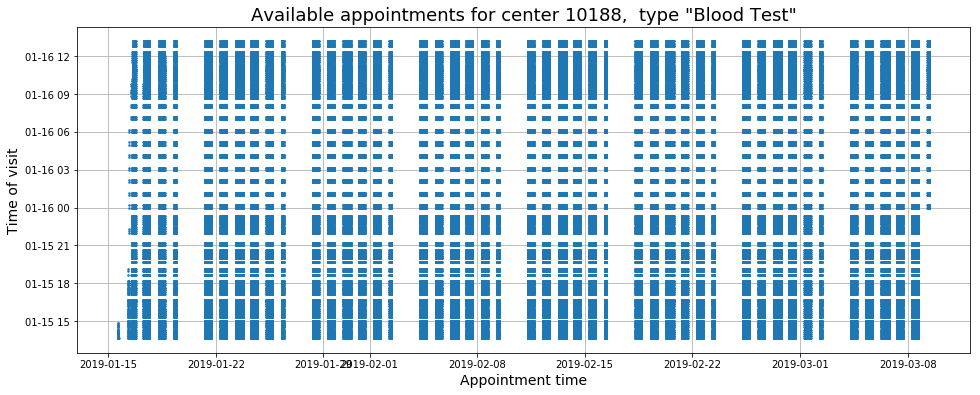

In [20]:
cid = 10188
test_type = 'Blood Test'
s0 = schedule.loc[(schedule['id'] == cid) & (schedule['test'] == test_type), ['id', 'test', 'appointment', 'grab']]
fig, ax = plt.subplots(figsize=(16, 6));
ax.plot(s0['appointment'], s0['grab'], **{'marker': '.', 'markersize': 3, "linestyle": ""});
ax.grid();
ax.set_title('Available appointments for center {0},  type "{1}"'.format(cid, test_type), fontsize=18);
ax.set_xlabel("Appointment time", fontsize=14);
ax.set_ylabel("Time of visit", fontsize=14);

Not all appointments in the future are accessible online at all times.  In this section of the notebook we will investigate how many days the appointments are posted ahead of time across all centers and test types.  

### Main questions

1. Do all appointments on a new day go online at the same time?
1. If so, how many days ahead, and at what time?
1. Do all test centers follow the same rule?

### Data collection period spans 24 hours. 
The dataset that is used in this notebook is relatively small and correponds to data collected over a period of roughly 24 hours.  This remark will be important when we investigate when the appointments go online and when we compute the timestamps of `first appearance`.  

### Timestamps of `first appearance`
We calculate the timestamps of `first appearance`, that is, the `grab` timestamp when an `appointment` first appears in `schedule`.  Except for the very first results, this should indicate when the `appointment` first appeared online.  

(Remark: the `groupby` method performs type conversion, and in order to avoid errors when converting back to timezone aware datetime objects, it is safer to convert timestamps to the UTC standard.)

In [21]:
first_appearance = schedule.copy()
first_appearance['appointment'] = first_appearance['appointment'].apply(
    lambda ts: ts.tz_convert(tz_utc)
)

first_appearance = first_appearance.groupby(
    ['id', 'test', 'appointment']
)[['grab']].min()
first_appearance.rename(
    index=str,
    columns={'grab': 'first appearance'},
    inplace=True
)


first_appearance.reset_index(inplace=True)
first_appearance['appointment'] = pd.to_datetime(
    first_appearance['appointment']
)
first_appearance['appointment'] = \
    first_appearance['appointment'].apply(
        lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_london)
    )
first_appearance['id'] = first_appearance['id'].astype(int)

first_appearance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54780 entries, 0 to 54779
Data columns (total 4 columns):
id                  54780 non-null int64
test                54780 non-null object
appointment         54780 non-null datetime64[ns, Europe/London]
first appearance    54780 non-null datetime64[ns, Europe/London]
dtypes: datetime64[ns, Europe/London](2), int64(1), object(1)
memory usage: 1.7+ MB


We add three columns, where the `open window` column records the number of days the `first appearance` occurs before the `appointment date`:

In [22]:
first_appearance['appointment date'] = first_appearance['appointment'].apply(
    lambda ts: ts.date()
)
first_appearance['first appearance date'] = first_appearance['first appearance'].apply(
    lambda ts: ts.date()
)
first_appearance['open window'] = first_appearance['appointment date'] - first_appearance['first appearance date']
first_appearance.head()

,id,test,appointment,first appearance,appointment date,first appearance date,open window
0,10136,Fasting Bloods,2019-01-17 07:20:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days
1,10136,Fasting Bloods,2019-01-17 07:25:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days
2,10136,Fasting Bloods,2019-01-17 07:30:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days
3,10136,Fasting Bloods,2019-01-17 07:35:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days
4,10136,Fasting Bloods,2019-01-17 07:40:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days


With it, we find that for most appointment *dates*, there is only one `first appearance` timestamp:

In [23]:
first_appearance.groupby(
    ['id', 'test', 'appointment date'])['first appearance'].nunique(
).to_frame(
)['first appearance'].value_counts().to_frame().rename_axis(
    "nb of first appearance timestamps on a given day"
).rename(index=str, columns={"first appearance": "nb of occurrences"})

,nb of occurrences
nb of first appearance timestamps on a given day,
1,1354
2,19
3,4
4,3
8,2
9,1
5,1


In fact, given the size the dataframe `first_appearance`, there are few distinct `first appearance` timestamps (keeping in mind that the data collection period is roughly 24 hours):

In [24]:
first_appearance['first appearance'].nunique()

36

Let's look at the top 5 most occurring `first appearance` timestamps:

In [25]:
first_appearance['first appearance'].value_counts()[0:5].to_frame().rename_axis(
"first appearance timestamp"
).rename(index=str, columns={'first appearance': "nb of occurrences"})

,nb of occurrences
first appearance timestamp,
2019-01-15 13:40:00+00:00,53761
2019-01-16 00:00:00+00:00,660
2019-01-15 14:50:00+00:00,288
2019-01-16 08:00:00+00:00,7
2019-01-16 09:50:00+00:00,6


The most occurring timestamp corresponds to the first `grab` timestamp in the dataframe `schedule`:

In [26]:
schedule['grab'].min()

Timestamp('2019-01-15 13:40:00+0000', tz='Europe/London')

We will ignore this timestamp since it most likely is an artefact of the data collection having to start when the system is already in place.  

Our next goal is to verify that all appointments on a new date (in a given test center and for a given test type) start to be available at the same time.

### Classifying centers by `first appearance` timestamps
We record the two most occurring `first appearance` timestamps:

In [27]:
new_posting_timestamp_1 = first_appearance['first appearance'].value_counts().index[1]
new_posting_timestamp_2 = first_appearance['first appearance'].value_counts().index[2]

Next we look at the test centers with these `first appearance` values appearing in their data:

These two timestamps split the centers into two disjoint subsets:

In [28]:
df_centers_1 = first_appearance[first_appearance['first appearance'] == new_posting_timestamp_1]['id'].drop_duplicates().to_frame().reset_index(drop=True)
df_centers_2 = first_appearance[first_appearance['first appearance'] == new_posting_timestamp_2]['id'].drop_duplicates().to_frame().reset_index(drop=True)

pd.merge(df_centers_1, df_centers_2, how='inner', on='id')

,id


The resulting dataframe is empty, showing that the two sets are disjoint.

### Appointments with most occurring `first appearance` timestamp

The next most occuring `first appearance` timestamp falls at midnight:

In [29]:
new_posting_timestamp_1

Timestamp('2019-01-16 00:00:00+0000', tz='Europe/London')

  This strongly suggests that all appointments on a new day go online at midnight a certain number of days ahead (which we will calculate later).  
  
We test this conjecture by looking at the dates of the appointments for which this is indeed the first appearance:

In [30]:
first_appearance[first_appearance['first appearance'] == new_posting_timestamp_1].groupby(
    ['id', 'test']
)['appointment date'].unique().to_frame()

appointment date
id    test                                            
10188 Blood Test              [2019-01-16, 2019-03-09]
      INR Test                [2019-01-16, 2019-03-20]
10207 Blood Test                          [2019-03-20]
10243 Blood Test                          [2019-05-21]
      INR Test                            [2019-05-21]
10244 Blood Test                          [2019-04-11]
      INR Test                            [2019-04-11]
10250 Blood Test                          [2019-04-10]
      INR Test                            [2019-04-10]
10254 Blood Test                          [2019-03-20]
10263 Blood Test                          [2019-03-11]
10266 Blood Test                          [2019-04-11]
      INR Test                            [2019-04-11]
10299 Glucose Tolerance Test              [2019-05-21]
10301 Blood Test                          [2019-03-20]
10352 Blood Test                          [2019-04-11]
      INR Test                            [2019-04-11]
10449 Blood Test                          [2019-04-11]

A majority of the test centers (12 out of 18) appear in this table.
If we discard the appointments with a date `2019-01-16` (which occurs soon after the start of data collection), all appointments in this table with a `first appearance` timestamp of `2019-01-16 00:00:00` are on the same day (taking each test center and test type individually).  We should keep in mind that the data collection spanned a period of 24 hours.  

This table also shows that the different test centers choose to open their appointments with a different number of days ahead of time.  

On the other hand, again ignoring the `appointment` date of `2019-01-16`, all test centers, except center `10188`, choose to open their appointments for all test types at the same time.  This follows directly by inspection, or programmatically with:

In [31]:
first_appearance[first_appearance['first appearance'] == new_posting_timestamp_1].groupby(
    ['id'])['appointment date'].unique().to_frame()

,appointment date
id,
10188,"[2019-01-16, 2019-03-09, 2019-03-20]"
10207,[2019-03-20]
10243,[2019-05-21]
10244,[2019-04-11]
10250,[2019-04-10]
10254,[2019-03-20]
10263,[2019-03-11]
10266,[2019-04-11]
10299,[2019-05-21]


Let's look at the number of days the appointments are put online ahead of time.

In [32]:
df_open_window_1 = first_appearance[first_appearance['first appearance'] == new_posting_timestamp_1].groupby(
    ['id', 'test'])['open window'].unique().to_frame()['open window'].apply(
    lambda ow: ow[-1]).to_frame()
df_open_window_1

open window
id    test                              
10188 Blood Test                 52 days
      INR Test                   63 days
10207 Blood Test                 63 days
10243 Blood Test                125 days
      INR Test                  125 days
10244 Blood Test                 85 days
      INR Test                   85 days
10250 Blood Test                 84 days
      INR Test                   84 days
10254 Blood Test                 63 days
10263 Blood Test                 54 days
10266 Blood Test                 85 days
      INR Test                   85 days
10299 Glucose Tolerance Test    125 days
10301 Blood Test                 63 days
10352 Blood Test                 85 days
      INR Test                   85 days
10449 Blood Test                 85 days

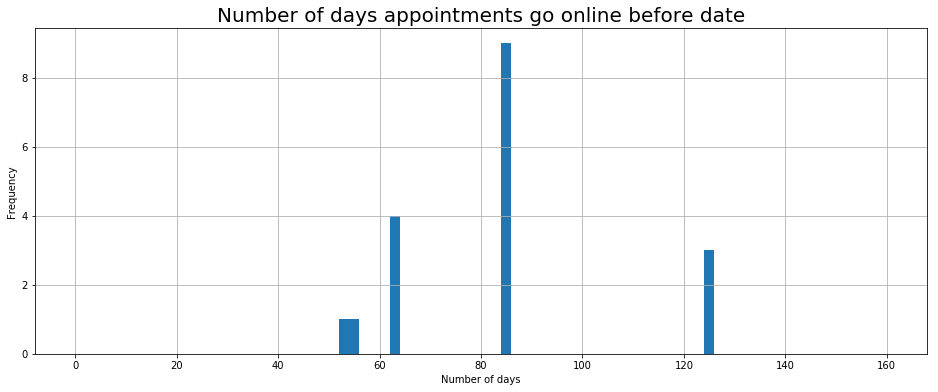

In [33]:
fig, ax = plt.subplots(figsize=(16, 6))
df_open_window_1['open window'].apply(lambda dt: dt.days).astype(int).hist(bins=80, range=(0, 160), ax=ax);
ax.set_title("Number of days appointments go online before date", fontsize=20)
ax.set_xlabel("Number of days");
ax.set_ylabel("Frequency");

### Appointments with next most occurring `first appearance` timestamp
We now perform the same analysis for the next most occurring `first appearance` timestamp:

In [34]:
new_posting_timestamp_2

Timestamp('2019-01-15 14:50:00+0000', tz='Europe/London')

The time of `14:50` is quite unusual.
Remember that the data was collected at discrete times:

In [35]:
schedule['grab'].unique()[6:9]

array([Timestamp('2019-01-15 14:40:00+0000', tz='Europe/London'),
       Timestamp('2019-01-15 14:50:00+0000', tz='Europe/London'),
       Timestamp('2019-01-15 15:00:00+0000', tz='Europe/London')],
      dtype=object)

Thus, the corresponding appointments have been posted any time between `14:40` and `14:50`.

As earlier, let's look at the appointment dates for which `new_posting_timestamp_2` is the `first appearance` timestamp:

In [36]:
first_appearance[first_appearance['first appearance'] == new_posting_timestamp_2].groupby(
    ['id', 'test'])['appointment date'].unique().to_frame()

appointment date
id    test                                        
10136 Fasting Bloods                  [2019-03-20]
      INR Test            [2019-01-16, 2019-04-04]
      Non Fasting Bloods  [2019-01-16, 2019-03-20]
10137 Blood Test                      [2019-05-03]
10138 Blood Test                      [2019-03-21]
10294 Blood Test                      [2019-03-20]
10341 Blood Test                      [2019-05-02]

We see that 5 out of the remaining 6 test centers appear in this table.
Similar conclusions hold: ignoring the date of `2019-01-16`, for any given test center and test type, all appointments with a `first appearance` timestamp of `2019-01-15 14:50:00` occur on the same day.

Let's look at the number of days the appointments are put online ahead of time:

In [37]:
df_open_window_2 = first_appearance[first_appearance['first appearance'] == new_posting_timestamp_2].groupby(
    ['id', 'test'])['open window'].unique().to_frame()['open window'].apply(
    lambda ow: ow[-1]).to_frame()
df_open_window_2

open window
id    test                          
10136 Fasting Bloods         64 days
      INR Test               79 days
      Non Fasting Bloods     64 days
10137 Blood Test            108 days
10138 Blood Test             65 days
10294 Blood Test             64 days
10341 Blood Test            107 days

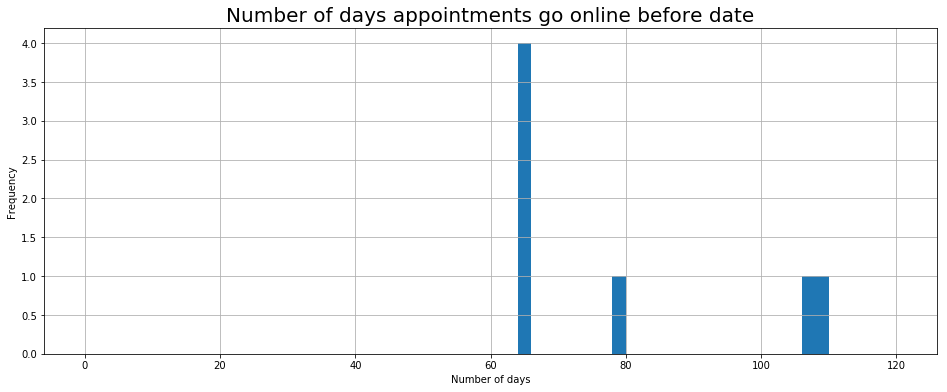

In [38]:
fig, ax = plt.subplots(figsize=(16, 6))
df_open_window_2['open window'].apply(lambda dt: dt.days).astype(int).hist(bins=60, range=(0, 120), ax=ax);
ax.set_title("Number of days appointments go online before date", fontsize=20)
ax.set_xlabel("Number of days");
ax.set_ylabel("Frequency");

We collect the two figures above into the one below:

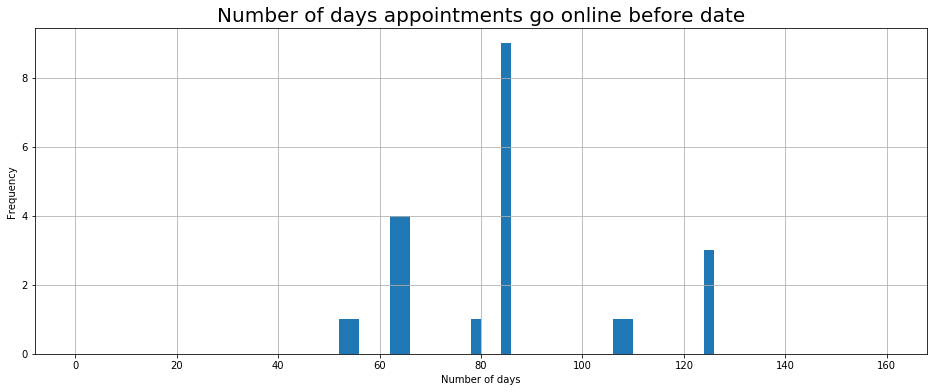

In [39]:
fig, ax = plt.subplots(figsize=(16, 6))

first_appearance[
    (first_appearance['first appearance'] == new_posting_timestamp_1)
    | (first_appearance['first appearance'] == new_posting_timestamp_2)].groupby(
    ['id', 'test'])['open window'].unique().to_frame()['open window'].apply(
    lambda ow: ow[-1]).to_frame()['open window'].apply(lambda dt: dt.days).astype(int).hist(bins=80, range=(0, 160), ax=ax);
ax.set_title("Number of days appointments go online before date", fontsize=20)
ax.set_xlabel("Number of days");
ax.set_ylabel("Frequency");
# plt.savefig('online-posting-period-distribution.png')

### The remaining test center
Let's now find the remaining center:

In [40]:
all_centers = set(schedule['id'].values)
centers_1 = set(df_centers_1['id'])
centers_2 = set(df_centers_2['id'])
remaining_center = list(all_centers.difference(centers_1.union(centers_2)))[0]
remaining_center

10336

Let's look at its data.  We already know that it delivers one test type:

In [41]:
list(schedule[schedule['id'] == remaining_center]['test'].unique())

['Blood Test']

Save it in a separate dataframe, for convenience:

In [42]:
schedule0 = schedule.loc[schedule['id'] == remaining_center, :].reset_index(drop=True)

We follow the procedure we used earlier for the entire dataframe `schedule` and  construct the dataframe `first_appearance0`:

In [43]:
first_appearance0 = schedule0.copy()
first_appearance0['appointment'] = first_appearance0['appointment'].apply(
    lambda ts: ts.tz_convert(tz_utc)
)

first_appearance0 = first_appearance0.groupby(
    ['id', 'test', 'appointment']
)[['grab']].min()
first_appearance0.rename(
    index=str,
    columns={'grab': 'first appearance'},
    inplace=True
)


first_appearance0.reset_index(inplace=True)
first_appearance0['appointment'] = pd.to_datetime(
    first_appearance0['appointment']
)
first_appearance0['appointment'] = \
    first_appearance0['appointment'].apply(
        lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_london)
    )
first_appearance0['id'] = first_appearance0['id'].astype(int)

first_appearance0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 4 columns):
id                  351 non-null int64
test                351 non-null object
appointment         351 non-null datetime64[ns, Europe/London]
first appearance    351 non-null datetime64[ns, Europe/London]
dtypes: datetime64[ns, Europe/London](2), int64(1), object(1)
memory usage: 11.0+ KB


In [44]:
first_appearance0['appointment date'] = first_appearance0['appointment'].apply(
    lambda ts: ts.date()
)
first_appearance0['first appearance date'] = first_appearance0['first appearance'].apply(
    lambda ts: ts.date()
)
first_appearance0['open window'] = first_appearance0['appointment date'] - first_appearance0['first appearance date']
first_appearance0.drop(['id', 'test'], axis=1, inplace=True)
first_appearance0.head()

,appointment,first appearance,appointment date,first appearance date,open window
0,2019-01-16 08:15:00+00:00,2019-01-15 13:40:00+00:00,2019-01-16,2019-01-15,1 days
1,2019-01-16 13:00:00+00:00,2019-01-15 13:40:00+00:00,2019-01-16,2019-01-15,1 days
2,2019-01-17 08:15:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days
3,2019-01-17 08:30:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days
4,2019-01-17 10:00:00+00:00,2019-01-15 13:40:00+00:00,2019-01-17,2019-01-15,2 days


For this center, *all* appointments appeared in `schedule0` at the same time (keeping in mind, as we have done all along, that the data was collected over a period of 24 hours):

In [45]:
first_appearance0['first appearance'].unique()

array([Timestamp('2019-01-15 13:40:00+0000', tz='Europe/London')],
      dtype=object)

Record time of end of script:

In [46]:
end_script = datetime.datetime.now()

run_time = end_script - beg_script
run_time

datetime.timedelta(seconds=285, microseconds=892362)

In [47]:
print("This script ran for: {0}min {1}sec.".format(run_time.seconds//60, run_time.seconds%60))

This script ran for: 4min 45sec.
